# Data Loader for CNN

# Imports

In [0]:
import numpy as np
import pandas as pd 

# Plotting imports
from seaborn import distplot

import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')

# Scikit-Learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split


# Loading Data

**What is being loaded?**: `outliersRemoved.csv` 
This data has is sorted, has no missing values and has no outliers. However, it is **not scaled**.

You will scale the data as you wish by running the cells in the **Scaling** section.

In [0]:
filepath = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv'

In [0]:
raw_data = pd.read_csv(filepath)

In [6]:
# Did it work?
raw_data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Extracting Features and Labels

In [0]:
# Column 2 onwards are kWhs, column 1 is the FLAG
kWhs = raw_data.iloc[:, 2:]
labels = raw_data.iloc[:, 1]

In [0]:
# Extracting number of rows and columns in the feature matrix
NUM_CONSUMERS, NUM_DAYS = kWhs.shape

In [9]:
print(NUM_CONSUMERS, NUM_DAYS)

42372 1034


# Scaling

Defining a single function to help scale data according to specified scaling strategy.

Under the hood it uses a `Scikit-Learn` feature scaler object to apply the right kind of feature scaling to the data. 

All you need to do is specify one of following values for the `scaling_strategy` argument
- `Standard`: all features will have mean of 0, standard deviation of 1.
- `MinMax`: all feature values `x` will be scaled according to `(x - x_min)/(x_max - x_min)`, where `x_min` and `x_max` are the minimum and maximum values for that feature.
- `MaxAbs`: all feature valeus `x` will be scaled according t `(x / abs(x_max))` where `x_max` is the maximum value of the feature, and `abs` is a function that finds its absolute value. 

Zheng has used `MinMax`, but my results show `Standard` to be more effective. 

You can also specify whether or not you want to compare the distribution of kWhs before and after scaling using the `plot_distributions` argument. **Plotting distributions will cause the function to take a little more time than usual to execute**.

In [0]:
def scale_features(X=kWhs, scaling_strategy='Standard', plot_distributions=False):
  """Allows user to scale features for individual samples using specified scaling strategy.
  `Standard` - all features scaled to have mean 0, standard deviation of 1
  `MinMax` - all features scaled according to x - x_min / (x_max - x_min)
  `MaxAbs` - all features scaled according to x / abs(x_max)
  
  Returns matrix of scaled features as a numpy array.

  Also allows before/after plots of feature values to compare effect of scaling
  """
  # StandardScaler - all features will have mean of 0, and std deviation of 1
  if (scaling_strategy=='Standard'):
    # Instantiate a StandardScaler object
    scaler = StandardScaler()
  elif (scaling_strategy=='MinMax'):
    scaler = MinMaxScaler()
  elif (scaling_strategy=='MaxAbs'):
    scaler = MaxAbsScaler()

  # Make a copy of the features, transpose so that consumers become columns
  X_copy = X.copy().transpose()

  # Once consumers are in columns, scale each consumer using scaler object and retranspose results 
  # Retransposing ensures that in scaled data, the consumers are still rows
  X_scaled = scaler.fit_transform(X_copy).transpose() # THIS IS A NUMPY ARRAY, NOT A DATAFRAME

  # If the user has asked to compare distributions
  if plot_distributions:
    # First figure - before scaling
    plt.figure(figsize=(12, 6))
    distplot(X.values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Unscaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - Before Scaling', fontsize=18)

    # Second figure - after scaling
    plt.figure(figsize=(12, 6))
    distplot(X_scaled.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Scaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - After {} Scaling'.format(scaling_strategy), fontsize=18)

  # Return the scaled features
  return X_scaled

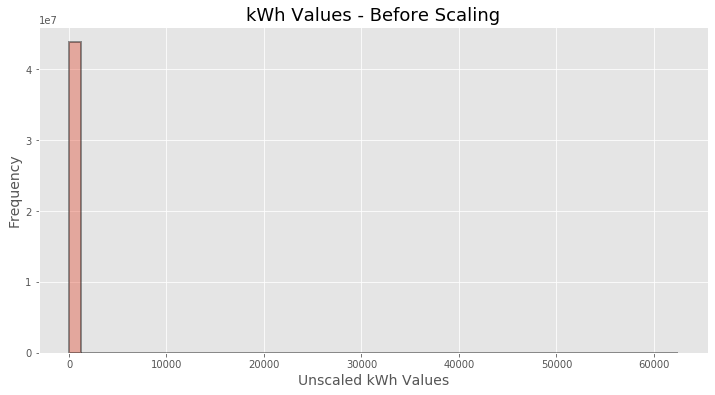

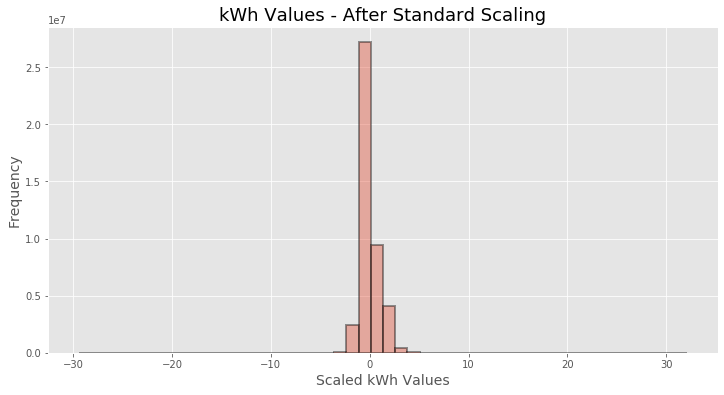

In [11]:
X_scaled_std = scale_features(X=kWhs, plot_distributions=True)

# Adding 2 Columns of Zeroes to Features

In [12]:
NUM_DAYS = 1034
DAYS_PER_WEEK = 7
NUM_WEEKS_FLOAT = NUM_DAYS / DAYS_PER_WEEK 
NUM_WEEKS = int(np.ceil(NUM_WEEKS_FLOAT))
print(f"Number of days per dataset: {NUM_DAYS}.\nNumber of days per week: {DAYS_PER_WEEK}")
print(f"So exact number of weeks: {NUM_WEEKS_FLOAT}\nWhich, when rounded up is {NUM_WEEKS}")
print(f"Which means new number of days is: {NUM_WEEKS * DAYS_PER_WEEK}")
print(f"Extra days to add: {NUM_WEEKS * DAYS_PER_WEEK - NUM_DAYS}")

Number of days per dataset: 1034.
Number of days per week: 7
So exact number of weeks: 147.71428571428572
Which, when rounded up is 148
Which means new number of days is: 1036
Extra days to add: 2


In [0]:
# 2 extra days per consumer 
X_scaled_std_padded = np.append(X_scaled_std, np.zeros((NUM_CONSUMERS, 2)), 
                                axis=1)

In [14]:
# Does it have the right shape?
X_scaled_std_padded.shape

(42372, 1036)

In [15]:
# Are the last two columns (and only the last two columns) zero?
pd.DataFrame(X_scaled_std_padded)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035
0,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,...,0.063220,0.561141,0.028722,0.106917,0.284007,0.265608,-0.005776,1.212002,0.377151,0.432348,1.410940,0.350703,0.178213,-0.101220,-0.102370,-0.172516,-0.132269,0.049421,0.036771,0.133366,-0.032224,0.467996,0.387501,0.060920,-0.036824,-0.108120,0.100018,-0.154117,-0.054073,0.048271,0.050571,0.216161,-0.249562,0.126466,0.189712,-0.012676,0.173613,-0.104670,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,...,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,1.440577,2.639282,2.639282,2.639282,2.639282,2.463751,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.048888,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,0.0,0.0
3,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,...,0.207467,1.742458,0.823156,1.524534,0.022337,0.391539,1.301320,1.110901,2.171960,0.889803,1.032617,1.884215,0.671879,0.482517,0.579842,0.713136,0.631679,0.991360,0.755451,0.924713,0.880282,0.812577,0.928945,0.827388,0.897208,0.574553,0.575611,0.602058,0.689863,0.934234,1.160621,0.912018,1.407109,1.534055,1.233616,1.372199,0.864414,0.574553,0.0,0.0
4,-1.095170,-0.485963,-0.185806,-1.001788,-0.937310,-0.550441,-0.688291,-0.921746,-0.955097,-0.979554,-0.892842,-0.721642,-0.948427,-0.795013,-0.881725,-0.955097,-0.981778,-1.550963,-1.544293,-0.892842,-0.292529,0.303338,-0.007936,-0.179136,-0.127999,-0.323656,-0.310316,0.014298,-0.081308,0.027638,-0.052404,-0.663834,-0.392581,-0.494857,-0.245838,-0.119105,-0.494857,-0.343667,-0.243614,-0.190253,...,0.616835,0.496772,0.659079,0.685760,2.211000,0.565697,1.263839,1.401689,2.137628,1.808568,0.968129,2.382201,1.248275,0.856960,0.294444,0.296668,0.525676,0.552357,0.045425,0.501219,0.559027,0.759131,1.626250,1.452827,1.014820,0.563473,0.325572,0.018745,1.419476,0.532346,0.1432

In [16]:
pd.DataFrame(X_scaled_std).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,-0.879724,...,0.104617,0.325404,0.063220,0.561141,0.028722,0.106917,0.284007,0.265608,-0.005776,1.212002,0.377151,0.432348,1.410940,0.350703,0.178213,-0.101220,-0.102370,-0.172516,-0.132269,0.049421,0.036771,0.133366,-0.032224,0.467996,0.387501,0.060920,-0.036824,-0.108120,0.100018,-0.154117,-0.054073,0.048271,0.050571,0.216161,-0.249562,0.126466,0.189712,-0.012676,0.173613,-0.104670
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,...,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,-0.503221,1.440577,2.639282,2.639282,2.639282,2.639282,2.463751,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.048888,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282,2.639282
3,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,-0.665288,...,1.164853,1.127827,0.207467,1.742458,0.823156,1.524534,0.022337,0.391539,1.301320,1.110901,2.171960,0.889803,1.032617,1.884215,0.671879,0.482517,0.579842,0.713136,0.631679,0.991360,0.755451,0.924713,0.880282,0.812577,0.928945,0.827388,0.897208,0.574553,0.575611,0.602058,0.689863,0.934234,1.160621,0.912018,1.407109,1.534055,1.233616,1.372199,0.864414,0.574553
4,-1.095170,-0.485963,-0.185806,-1.001788,-0.937310,-0.550441,-0.688291,-0.921746,-0.955097,-0.979554,-0.892842,-0.721642,-0.948427,-0.795013,-0.881725,-0.955097,-0.981778,-1.550963,-1.544293,-0.892842,-0.292529,0.303338,-0.007936,-0.179136,-0.127999,-0.323656,-0.310316,0.014298,-0.081308,0.027638,-0.052404,-0.663834,-0.392581,-0.494857,-0.245838,-0.119105,-0.494857,-0.343667,-0.243614,-0.190253,...,0.385603,0.367816,0.616835,0.496772,0.659079,0.685760,2.211000,0.565697,1.263839,1.401689,2.137628,1.808568,0.968129,2.382201,1.248275,0.856960,0.294444,0.296668,0.525676,0.552357,0.045425,0.501219,0.559027,0.759131,1.626250,1.452827,1.

# Reshaping the Data

Data will now be a 4-dimensional numpy array. This is because a `Conv2D` layer in the network expects a 4-dimensional array as an input. The axes of this array are as follows

- **Axis 0**: Samples axis - The consumer number in a particular batch. For our entire features matrix, this should range **from 0 to 42371**.
- **Axis 1**: Week axis - Each week of kWh values for that consumer (0 to 147)
- **Axis 2**: Day axis - Each day of kWh values for a specific week (0 to 6)
- **Axis 3**: Channels axis - `Conv2D` is meant to process images, which usually have a channels axis (1 channel for grayscale, 3 channels for RGB, HSV, LAB colour spaces). In this case, our data does not have multiple channels of readings per consumer. So channel should be **1**.

It may help to think of each consumer's reshaped data as a `(148, 7)` grid of squares, and the entire training data to be a **cube** of 42,372 such grids stacked together.

In [0]:
# Creating a new numpy array to store the training data - 4 dimensional because
# CNN expects 4D data - (samples, rows, cols, channels) - in our case 1 channel
NUM_CHANNELS = 1
X_reshaped = np.zeros((NUM_CONSUMERS, NUM_WEEKS, DAYS_PER_WEEK, NUM_CHANNELS))

In [0]:
def transform_daily_to_weekly(daily_kWhs):
  """Will simply reshape the 1D daily kWhs of a single consumer into 2D weekly data""" 
  return daily_kWhs.reshape(NUM_WEEKS, DAYS_PER_WEEK, NUM_CHANNELS)

In [0]:
# Applying this function to every consumer in the original dataset
# And saving the (148, 7) kWhs matrix for that consumer at the ith index in 3D array
for i in range(0, NUM_CONSUMERS):
  X_reshaped[i] = transform_daily_to_weekly(X_scaled_std_padded[i])

## Indexing Reshaped Data

In [20]:
# Entire reshaped data's shape
X_reshaped.shape

(42372, 148, 7, 1)

In [21]:
# To access the kWhs of the 1st consumer
X_reshaped[0]

array([[[-0.87972438],
        [-0.87972438],
        [-0.87972438],
        ...,
        [-0.87972438],
        [-0.87972438],
        [-0.87972438]],

       [[-0.87972438],
        [-0.87972438],
        [-0.87972438],
        ...,
        [-0.87972438],
        [-0.87972438],
        [-0.87972438]],

       [[-0.87972438],
        [-0.87972438],
        [-0.87972438],
        ...,
        [-0.87972438],
        [-0.87972438],
        [-0.87972438]],

       ...,

       [[ 0.13336578],
        [-0.03222444],
        [ 0.46799602],
        ...,
        [ 0.06092006],
        [-0.03682416],
        [-0.10811995]],

       [[ 0.10001775],
        [-0.15411724],
        [-0.05407315],
        ...,
        [ 0.05057067],
        [ 0.2161609 ],
        [-0.2495616 ]],

       [[ 0.12646619],
        [ 0.18971246],
        [-0.01267559],
        ...,
        [-0.10467016],
        [ 0.        ],
        [ 0.        ]]])

In [22]:
# Shape of this tensor?
print("Shape of the 1st consumer's tensor: ", X_reshaped[0].shape)

Shape of the 1st consumer's tensor:  (148, 7, 1)


In [23]:
# To access the kWhs of the 1st week for this consumer
X_reshaped[0][0]

array([[-0.87972438],
       [-0.87972438],
       [-0.87972438],
       [-0.87972438],
       [-0.87972438],
       [-0.87972438],
       [-0.87972438]])

In [24]:
# Shape of this tensor?
print("Shape of the 1st consumer's 1st week's tensor", X_reshaped[0][0].shape)

Shape of the 1st consumer's 1st week's tensor (7, 1)


In [25]:
# To access the kWhs of the 1st day of the 1st week
X_reshaped[0][0][0]

array([-0.87972438])

In [26]:
# Comparing with the first consumer's original values
X_scaled_std_padded[0, :15]

array([-0.87972438, -0.87972438, -0.87972438, -0.87972438, -0.87972438,
       -0.87972438, -0.87972438, -0.87972438, -0.87972438, -0.87972438,
       -0.87972438, -0.87972438, -0.87972438, -0.87972438, -0.87972438])

Seem correct. All values are the same because first 15 valeues for this consumer were probably all the same i.e. 0.

## Train-Test Split

I am using a function from `sklearn` called `train_test_split` that will divide the features and labels into **stratified** training and test sets.

This function returns four `numpy` arrays: `X_train`, `X_test`, `y_train`, and `y_test` (in that order) which are the features and labels for the training and test sets respectively. 

Stratified means both training and test sets will have the same proportion of samples belonging to classes 0 and 1. Since we will be stratifying on the basis of the labels, we need to specify this in the `stratify` argument for this function. 

By specifying `test_size` = 0.2, I am reserving 20% of the samples for the test set and 80% of samples for the training set.

I am also going to specify a `random_state` so that the random number generator will generate the same indexes for train and test sets every time the notebook is run. This is useful to ensure that every time we run the notebook, the training and test sets contain the same samples.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, 
                                                    labels, 
                                                    stratify=labels, 
                                                    test_size=0.2)

In [0]:
# Confirming train-test split performed correctly
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

# Next Steps 

Now the CNN should work. All your data is 2-dimensional `(148, 7)`, and you have one label in `y` for each 3D tensor of a sample. 

The 3D tensor is, in effect, a 2D tensor with just one channel. This is a hack so that we can use a `Conv2D` layer with non-image data.

# CNN 1 - Conv2D/MaxPooling

In [0]:
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential

In [0]:
model = Sequential()

In [0]:
# First conv-pooling pair
model.add(Conv2D(input_shape=(148, 7, 1), kernel_size=(3, 3), filters=18, 
                 activation='tanh', padding='same', data_format='channels_last', ))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [209]:
# After this pair
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 3, 18)         0         
Total params: 180
Trainable params: 180
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Adding second conv-pooling layer
model.add(Conv2D(filters=36, kernel_size=(3, 3), activation='tanh', padding='same', 
                 data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [211]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 3, 18)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 74, 3, 36)         5868      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 37, 1, 36)         0         
Total params: 6,048
Trainable params: 6,048
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Won't be able to add a third pair of conv-pooling layers
model.add(Conv2D(filters=72, kernel_size=(3, 3), activation='tanh', padding='same', 
                 data_format='channels_last'))

In [213]:
# After the conv-layer
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 3, 18)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 74, 3, 36)         5868      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 37, 1, 36)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 37, 1, 72)         23400     
Total params: 29,448
Trainable params: 29,448
Non-trainable params: 0
_________________________________________________________________


In [214]:
# Add a pooling layer?
model.add(MaxPooling2D(pool_size=(2, 2)))

ValueError: ignored

Cannot add another `MaxPooling2D` layer. There input tensor is too small.

# CNN 2 - One Pooling Layer 

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Available in the tensorflow distribution of keras only
from tensorflow.keras.metrics import AUC

In [0]:
# Create a new model
model = Sequential()

## Conv1

In [0]:
# Add first convolutional layer
model.add(Conv2D(filters=18, input_shape=(148, 7, 1), kernel_size=(3, 3), padding='same',
                 data_format='channels_last', activation='tanh'))

In [79]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 7, 18)        180       
Total params: 180
Trainable params: 180
Non-trainable params: 0
_________________________________________________________________


## Conv2

In [80]:
# Add second convolutional layer
model.add(Conv2D(filters=18, kernel_size=(3, 3), padding='same',
                 data_format='channels_last', activation='tanh'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 148, 7, 18)        2934      
Total params: 3,114
Trainable params: 3,114
Non-trainable params: 0
_________________________________________________________________


## Conv3

In [81]:
# Add a third convolutional layer
model.add(Conv2D(filters=18, kernel_size=(3, 3), padding='same', 
                 data_format='channels_last', activation='tanh'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 148, 7, 18)        2934      
Total params: 6,048
Trainable params: 6,048
Non-trainable params: 0
_________________________________________________________________


## Conv4

In [82]:
# Add a fourth convolutional layer
model.add(Conv2D(filters=18, kernel_size=(3, 3), padding='same', 
                 data_format='channels_last', activation='tanh'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 148, 7, 18)        2934      
Total params: 8,982
Trainable params: 8,982
Non-trainable params: 0
_________________________________________________________________


## Conv5

In [83]:
# Add a fifth convolutional layer
model.add(Conv2D(filters=18, kernel_size=(3, 3), padding='same', 
                 data_format='channels_last', activation='tanh'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 148, 7, 18)        2934      
Total params: 11,916
Trainable params: 11,916
Non-trainable params: 0
_________________________________________________________________


## Pooling

In [84]:
# Add a single max pooling layer
model.add(MaxPooling2D(pool_size=(7, 7)))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 1, 18)         0         
Total params: 11,916
Trainable params: 11,916
Non-trainable params: 0
__________________________________________________

## Densely Connected Classifier

In [85]:
# Must flatten the model first 
model.add(Flatten())
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 1, 18)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 378)              

In [86]:
# Zheng's results show max AUC with ~64 neurons at training ratio of 0.8
# Described as 'similar to wide component' so activation chosen as relu
model.add(Dense(units=64, activation='relu'))    
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 1, 18)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 378)              

## Sigmoid Activation 

In [0]:
model.add(Dense(units=1, activation='sigmoid'))

In [88]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 7, 18)        180       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 148, 7, 18)        2934      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 1, 18)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 378)              

## Compiling the Model

In [0]:
# Compile the model
model.compile(optimizer='rmsprop',               # Unspecified in paper. Assumed
              loss='binary_crossentropy')        # Log loss
# AUC needs a little more work than just instantiating an object.
# Go over the documentation with supervisor
              # metrics=[AUC()])                   # Only available in tf distribution of keras

## Training Model

In [90]:
# Train the model
model_history = model.fit(x=X_train, y=y_train,      # Training data 
                          batch_size=128,            # Unspecified in paper. Assumed
                          epochs=20,                 # From figure 9b
                          validation_split=0.2,      # Unspecified. Assumed
                          verbose=1)

Train on 27117 samples, validate on 6780 samples
Epoch 1/20
27117/27117 [==============================] - 3s 107us/step - loss: 0.2867 - val_loss: 0.2835
Epoch 2/20
27117/27117 [==============================] - 2s 85us/step - loss: 0.2680 - val_loss: 0.2717
Epoch 3/20
27117/27117 [==============================] - 2s 81us/step - loss: 0.2574 - val_loss: 0.2553
Epoch 4/20
27117/27117 [==============================] - 2s 80us/step - loss: 0.2507 - val_loss: 0.2584
Epoch 5/20
27117/27117 [==============================] - 2s 81us/step - loss: 0.2455 - val_loss: 0.2541
Epoch 6/20
27117/27117 [==============================] - 2s 81us/step - loss: 0.2398 - val_loss: 0.2538
Epoch 7/20
27117/27117 [==============================] - 2s 79us/step - loss: 0.2360 - val_loss: 0.2555
Epoch 8/20
27117/27117 [==============================] - 2s 81us/step - loss: 0.2319 - val_loss: 0.2582
Epoch 9/20
27117/27117 [==============================] - 2s 80us/step - loss: 0.2278 - val_loss: 0.2510
Epoch

In [0]:
def plot_history(history, model_name, has_metrics=False, metric_name=None, 
                 loss_metric=None):
  """Plots training and validation loss, as well as optional metric"""
  # Extract loss from the history object
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = np.arange(1, len(loss) + 1)

  # Create a new figure for plotting loss
  plt.figure(figsize=(12, 6))
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs', fontsize=14)
  plt.ylabel('Loss' if loss_metric is not None else loss_metric, fontsize=14)
  plt.title('Training vs Validation Loss \n{}'.format('' if model_name is None else model_name), 
            fontsize=18)
  plt.legend()

  # If the user has also asked to plot a metric
  if has_metrics and metric_name is not None:
    # Create a new figure for plotting the metric
    plt.figure(figsize=(12, 6))
    metric = history.history[metric_name]
    val_metric = history.history['val_{}'.format_metric_name]
    
    plt.plot(epochs, metric, label='Training')
    plt.plot(epochs, val_metric, label='Validation')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.title('Training vs Validation Loss {}'.format(metric_name), fontsize=18)
    plt.legend()

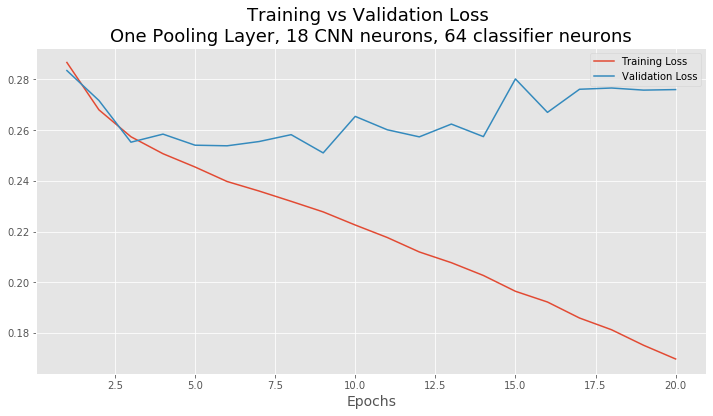

In [99]:
plot_history(history=model_history, 
             model_name='One Pooling Layer, 18 CNN neurons, 64 classifier neurons')